<a href="https://colab.research.google.com/github/Deeksha-Pandit/EVA4-Phase2/blob/master/Session4_Face_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!pip install -q torch==1.5.0 torchvision==0.6.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install facenet-pytorch

     |████████████████████████████████| 603.7MB 30kB/s 
     |████████████████████████████████| 6.5MB 34.4MB/s 
     |████████████████████████████████| 1.9MB 5.3MB/s 


In [3]:
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.nn.init import *
from torchvision import transforms, utils, datasets, models

import cv2
from PIL import Image
from pdb import set_trace
import time
import copy
from pathlib import Path
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage import io, transform
from tqdm import trange, tqdm
import csv
import glob
import dlib
import pandas as pd
import numpy as np
import shutil
from torchsummary import summary

In [4]:
from facenet_pytorch.models.inception_resnet_v1 import InceptionResnetV1

In [5]:
LFW_dataset_URL = 'http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz'
!wget http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz

--2020-08-23 12:49:22--  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 243346528 (232M) [application/x-gzip]
Saving to: ‘lfw-funneled.tgz’

lfw-funneled.tgz    100%[===================>] 232.07M  38.4MB/s    in 7.4s    

2020-08-23 12:49:30 (31.2 MB/s) - ‘lfw-funneled.tgz’ saved [243346528/243346528]



In [6]:
!tar zxf lfw-funneled.tgz

In [7]:
gdrive_path = '/content/gdrive/My Drive/S4_FacialRecognition/'

In [8]:

if not os.path.exists("data"):
    shutil.copy(os.path.join(gdrive_path, "lfw_dataset.zip"), os.getcwd())
    os.mkdir("data")
    !unzip -q lfw_dataset.zip -d data/
    

In [9]:

## No prep required.
data_folder = './data/lfw_dataset'
!ls './data/lfw_dataset/train' | wc

    620     620    9020


In [10]:
class_folders = [ f.path for f in os.scandir("lfw_funneled") if f.is_dir() ]

In [11]:
print(len(class_folders))
print(class_folders[:5])

5749
['lfw_funneled/Sonya_Walger', 'lfw_funneled/Jorge_Marquez-Ruarte', 'lfw_funneled/Bill_Parsons', 'lfw_funneled/Eve_Pelletier', 'lfw_funneled/Anne_Donovan']


In [12]:

paths_train = glob.glob('./data/lfw_dataset/train/*/*')
paths_test = glob.glob('./data/lfw_dataset/val/*/*')

In [13]:
print(len(paths_train))
print(len(paths_test))

5022
1811


In [14]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
data_transforms = {
    'train': transforms.Compose([
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean, std)                                 
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [15]:

image_datasets = {x: datasets.ImageFolder(os.path.join(data_folder, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8, shuffle=True) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}

class_names = image_datasets['train'].classes
class_names

['Aaron_Peirsol',
 'Abdoulaye_Wade',
 'Abdullah',
 'Abdullah_Gul',
 'Abel_Pacheco',
 'Adam_Sandler',
 'Adrien_Brody',
 'Ahmed_Chalabi',
 'Ai_Sugiyama',
 'Al_Gore',
 'Al_Sharpton',
 'Alan_Greenspan',
 'Alastair_Campbell',
 'Albert_Costa',
 'Alec_Baldwin',
 'Alejandro_Toledo',
 'Aleksander_Kwasniewski',
 'Alexander_Downer',
 'Alexander_Losyukov',
 'Ali_Naimi',
 'Allyson_Felix',
 'Alvaro_Silva_Calderon',
 'Alvaro_Uribe',
 'Amanda_Bynes',
 'Amelia_Vega',
 'Amelie_Mauresmo',
 'Amer_al-Saadi',
 'Ana_Guevara',
 'Ana_Palacio',
 'Anders_Fogh_Rasmussen',
 'Andre_Agassi',
 'Andy_Roddick',
 'Angela_Bassett',
 'Angela_Merkel',
 'Angelina_Jolie',
 'Angelo_Reyes',
 'Ann_Veneman',
 'Anna_Kournikova',
 'Antonio_Banderas',
 'Antonio_Palocci',
 'Antony_Leung',
 'Ari_Fleischer',
 'Arianna_Huffington',
 'Ariel_Sharon',
 'Arminio_Fraga',
 'Arnold_Schwarzenegger',
 'Arnoldo_Aleman',
 'Art_Howe',
 'Ashanti',
 'Atal_Bihari_Vajpayee',
 'Augustin_Calleri',
 'Ayushmann_Khurrana',
 'Azra_Akin',
 'Barbara_Walters',

In [16]:
def denormalize(tensor, mean, std):
    if not tensor.ndimension() == 4:
        raise TypeError('tensor should be 4D')

    mean = torch.FloatTensor(mean).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)
    std = torch.FloatTensor(std).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)

    return tensor.mul(std).add(mean)

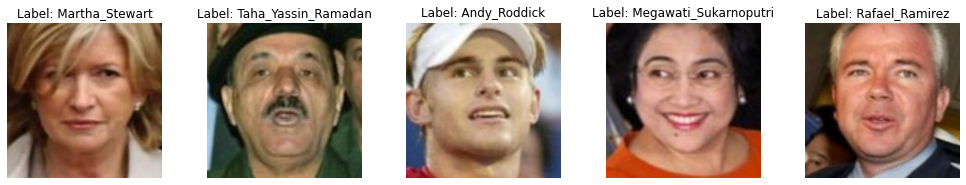

In [17]:

def display_image_class(image_array, label_array, class_names, fig_size = (14, 14)):
    '''
    Displays images along with their class name along a row.
    Input:
        Image_array (tensor array): Denormalized Tensor array of images to be displayed.
        label_array (tensor array): Tensor with class map od images.
        classes (dictionary): Dictionary containing class map and class name.
        fig_size (tuple): display size of each figure

    Output:
        matplot figure. 
    '''
    fig, axs = plt.subplots(1, len(image_array), figsize = fig_size)
    fig.tight_layout()

    for i in range(len(image_array)):
        axs[i].axis("off")
        axs[i].set_title(f'Label: {class_names[label_array[i]]}')
        axs[i].imshow(image_array[i].permute(1,2,0))
inputs, classes = next(iter(dataloaders['train']))
inputs_denormalized = denormalize(inputs[:5], mean, std)

display_image_class(inputs_denormalized, classes[:5], class_names)

In [18]:
model_ft = InceptionResnetV1(pretrained='vggface2', classify=False, num_classes=len(class_names))

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print('Running on device: {}'.format(device))

Running on device: cuda


In [20]:
model_ft

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [21]:
list(model_ft.children())[:6]

[BasicConv2d(
   (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
   (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU()
 ), BasicConv2d(
   (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
   (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU()
 ), BasicConv2d(
   (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU()
 ), MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False), BasicConv2d(
   (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU()
 ), BasicConv2d(
   (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
   (bn): BatchNorm2d(192, eps=0.0

In [22]:
layer_list = list(model_ft.children())[-5:] # all final layers

In [23]:
layer_list

[AdaptiveAvgPool2d(output_size=1),
 Dropout(p=0.6, inplace=False),
 Linear(in_features=1792, out_features=512, bias=False),
 BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
 Linear(in_features=512, out_features=8631, bias=True)]

In [24]:
# Keeping all the layers bar the last 5 in nn.Sequential.
model_ft = nn.Sequential(*list(model_ft.children())[:-5])

In [25]:
# Freeze gradient updation for the top layers.
for param in model_ft.parameters():
    param.requires_grad = False

In [26]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x
class normalize(nn.Module):
    def __init__(self):
        super(normalize, self).__init__()
        
    def forward(self, x):
        x = F.normalize(x, p=2, dim=1)
        return x

In [27]:
# Apply the final layers back into the model.
model_ft.avgpool_1a = nn.AdaptiveAvgPool2d(output_size=1)
model_ft.last_linear = nn.Sequential(
    Flatten(),
    nn.Linear(in_features=1792, out_features=512, bias=False),
    normalize()
)
model_ft.logits = nn.Linear(layer_list[4].in_features, len(class_names))
#model_ft.softmax = nn.Softmax(dim=1)

In [28]:
summary(model_ft, input_size=(3, 224, 224))

RuntimeError: ignored

In [29]:
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=1, momentum=0.9)
# Decay LR by a factor of *gamma* every *step_size* epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=100, gamma=0.1)

In [30]:
def train_model(model, criterion, optimizer, scheduler,
                num_epochs=25):
    since = time.time()
    FT_losses = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

    # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()                        
                
                FT_losses.append(loss.item())
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            # Calculated once for train, test for each epoch.
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        # Scheduler- learning step updated after one epoch train and test
        scheduler.step()
        print(("Epoch-", epoch, "LR rate-", optimizer.param_groups[0]['lr']))
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, FT_losses

Epoch 0/14
----------
train Loss: 4.0579 Acc: 0.3524
val Loss: 2.1340 Acc: 0.6195
('Epoch-', 0, 'LR rate-', 1)
Epoch 1/14
----------
train Loss: 2.0362 Acc: 0.6348
val Loss: 1.2128 Acc: 0.7835
('Epoch-', 1, 'LR rate-', 1)
Epoch 2/14
----------
train Loss: 1.1655 Acc: 0.8047
val Loss: 0.7898 Acc: 0.8868
('Epoch-', 2, 'LR rate-', 1)
Epoch 3/14
----------
train Loss: 0.7013 Acc: 0.9138
val Loss: 0.5382 Acc: 0.9348
('Epoch-', 3, 'LR rate-', 1)
Epoch 4/14
----------
train Loss: 0.4434 Acc: 0.9576
val Loss: 0.4324 Acc: 0.9542
('Epoch-', 4, 'LR rate-', 1)
Epoch 5/14
----------
train Loss: 0.3075 Acc: 0.9795
val Loss: 0.3590 Acc: 0.9586
('Epoch-', 5, 'LR rate-', 1)
Epoch 6/14
----------
train Loss: 0.2213 Acc: 0.9869
val Loss: 0.3295 Acc: 0.9553
('Epoch-', 6, 'LR rate-', 1)
Epoch 7/14
----------
train Loss: 0.1796 Acc: 0.9910
val Loss: 0.2952 Acc: 0.9696
('Epoch-', 7, 'LR rate-', 1)
Epoch 8/14
----------
train Loss: 0.1464 Acc: 0.9924
val Loss: 0.2704 Acc: 0.9707
('Epoch-', 8, 'LR rate-', 1)
E

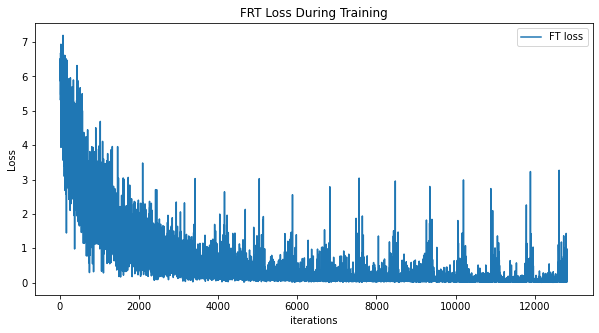

In [31]:
model_ft, FT_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=15)
plt.figure(figsize=(10,5))
plt.title("FRT Loss During Training")
plt.plot(FT_losses, label="FT loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [33]:
model_ft.to('cpu')
model_ft.eval()
traced_model=torch.jit.trace(model_ft,torch.randn(1,3,224,224))
traced_model.save('/content/inceptionresnet.pt')